<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.1.1: K-Means by the algorithm

### Australian athletes data set

##### Description
These data were collected in a study of how data on various characteristics of the bloood varied with sport body size and sex of the athlete.

Usage
data(ais)
Format
A data frame with 202 observations on the following 13 variables.

rcc
red blood cell count, in

wcc
while blood cell count, in per liter

hc
hematocrit, percent

hg
hemaglobin concentration, in g per decaliter

ferr
plasma ferritins, ng

bmi
Body mass index, kg

ssf
sum of skin folds

pcBfat
percent Body fat

lbm
lean body mass, kg

ht
height, cm

wt
weight, kg

sex
a factor with levels f m

sport
a factor with levels B_Ball Field Gym Netball Row Swim T_400m T_Sprnt Tennis W_Polo

Details
Do blood hemoglobin concentrations of athletes in endurance-related events differ from those in power-related events?

Source
These data were the basis for the analyses that are reported in Telford and Cunningham (1991).

References
Telford, R.D. and Cunningham, R.B. 1991. Sex, sport and body-size dependency of hematology in highly trained athletes. Medicine and Science in Sports and Exercise 23: 788-794.

**References**

[Data](http://vincentarelbundock.github.io/Rdatasets/csv/DAAG/ais.csv)

[Data Dictionary](http://vincentarelbundock.github.io/Rdatasets/doc/DAAG/ais.html)

In [2]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

### 1. Import the data

In [3]:
csv_file = 'ais.csv'
df = pd.read_csv('ais.csv')

### 2. Do some EDA of relationships between features.

In [31]:
df.head()

,Unnamed: 0,rcc,wcc,hc,hg,ferr,bmi,ssf,pcBfat,lbm,ht,wt,sex,sport
0,1,3.96,7.5,37.5,12.3,60,20.56,109.1,19.75,63.32,195.9,78.9,f,B_Ball
1,2,4.41,8.3,38.2,12.7,68,20.67,102.8,21.30,58.55,189.7,74.4,f,B_Ball
2,3,4.14,5.0,36.4,11.6,21,21.86,104.6,19.88,55.36,177.8,69.1,f,B_Ball
3,4,4.11,5.3,37.3,12.6,69,21.88,126.4,23.66,57.18,185.0,74.9,f,B_Ball
4,5,4.45,6.8,41.5,14.0,29,18.96,80.3,17.64,53.20,184.6,64.6,f,B_Ball


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  202 non-null    int64  
 1   rcc         202 non-null    float64
 2   wcc         202 non-null    float64
 3   hc          202 non-null    float64
 4   hg          202 non-null    float64
 5   ferr        202 non-null    int64  
 6   bmi         202 non-null    float64
 7   ssf         202 non-null    float64
 8   pcBfat      202 non-null    float64
 9   lbm         202 non-null    float64
 10  ht          202 non-null    float64
 11  wt          202 non-null    float64
 12  sex         202 non-null    object 
 13  sport       202 non-null    object 
dtypes: float64(10), int64(2), object(2)
memory usage: 22.2+ KB


In [33]:
df.shape

(202, 14)

In [34]:
df.isnull().sum()

Unnamed: 0    0
rcc           0
wcc           0
hc            0
hg            0
ferr          0
bmi           0
ssf           0
pcBfat        0
lbm           0
ht            0
wt            0
sex           0
sport         0
dtype: int64

In [35]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [36]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

<AxesSubplot:>

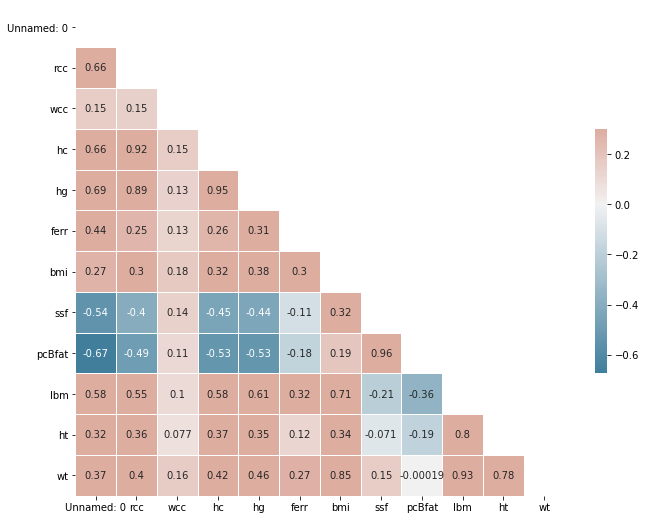

In [37]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [4]:
#label encode categorical features
from sklearn.preprocessing import LabelEncoder
#sex
labelEncoder = LabelEncoder()
labelEncoder.fit(df['sex'])
df['sex'] = labelEncoder.transform(df['sex'])

In [5]:
labelEncoder.fit(df['sport'])
df['sport'] = labelEncoder.transform(df['sport'])

In [6]:
#sport count with respect to haemoglobin:
df[['sport', 'hg']].groupby(['hg'], as_index=False).mean().sort_values(by='hg', ascending=False)

,hg,sport
54,19.2,7.000000
53,18.5,7.000000
52,18.0,1.000000
51,17.7,8.000000
50,17.3,4.000000
49,17.2,8.000000
48,16.8,6.000000
47,16.7,1.000000
46,16.5,6.000000
45,16.4,0.000000


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  202 non-null    int64  
 1   rcc         202 non-null    float64
 2   wcc         202 non-null    float64
 3   hc          202 non-null    float64
 4   hg          202 non-null    float64
 5   ferr        202 non-null    int64  
 6   bmi         202 non-null    float64
 7   ssf         202 non-null    float64
 8   pcBfat      202 non-null    float64
 9   lbm         202 non-null    float64
 10  ht          202 non-null    float64
 11  wt          202 non-null    float64
 12  sex         202 non-null    int64  
 13  sport       202 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 22.2 KB


### 3. Prepare the data for clustering

1. Remove the `sex`, `sport` column. We will see if the clusters from K-Means end up like the actual sex.
2. Put the features on the same scale.

In [64]:
#df = df.drop(['Unnamed: 0','rcc', 'wcc','hc', 'ferr', 'bmi', 'ssf', 'pcBfat', 'lbm', 'ht', 'wt'], axis=1)

In [7]:
X = np.array(df.drop(['sex', 'sport'], 1).astype(float))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#y = np.array(df['sex'])

In [8]:
X.shape

(202, 12)

### 4. Clustering with K-Means

- Cluster the data to our our target groups.
    - Use sklearn.cluster.KMeans
- We know that there are 2 actual classes. Lets try using 2, 4. Run the clustering algorithm with each of those k values.

In [9]:
# ANSWER
from sklearn.cluster import KMeans
model_2c = KMeans(n_clusters = 2)
model_4c = KMeans(n_clusters = 4)

In [10]:
results_2c = model_2c.fit(X)
results_4c = model_4c.fit(X)

In [12]:
prediction_2c = model_2c.predict(X)
prediction_4c = model_4c.predict(X)

In [56]:
#drop in accuracy we wont use scaled data

### 5. Get the labels for the models

In [15]:
model_2c.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1], dtype=int32)

In [16]:
model_4c.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1, 0, 2,
       2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1,
       2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1,
       1, 2, 2, 1], dtype=int32)

### 6. Elbow Method For Optimal k

For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre. As k increases, the sum of squared distance tends to zero. 

In [87]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [84]:
# ANSWER

# Creating the data
x1 = np.array(df.sex)
x2 = np.array(df.sport)
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)
 

Below is a plot of sum of squared distances for k in the range specified above. If the plot looks like an arm, then the elbow on the arm is optimal k.

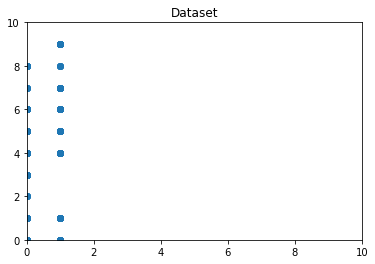

In [85]:
# ANSWER
# Visualizing the data
plt.plot()
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Sex and Sport')
plt.scatter(x1, x2)
plt.show()

In [88]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [89]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 2.315038308046489
2 : 1.476241404996314
3 : 0.9445219965618505
4 : 0.7274608387619066
5 : 0.615405277835289
6 : 0.5463293620907411
7 : 0.4982481010160529
8 : 0.44444341195672776
9 : 0.3464439539543747


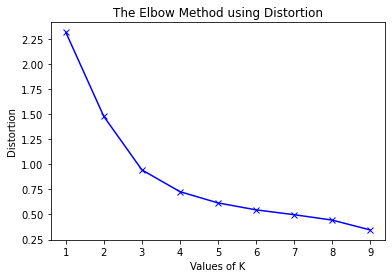

In [90]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

### 7. Plot `ht` vs. `wt` using the clusters from each model.

- Plot ht, wt using hue sex
- Plot ht, wt using hue label

Each time, compare to the actual species classification.

In [21]:
df

,Unnamed: 0,rcc,wcc,hc,hg,ferr,bmi,ssf,pcBfat,lbm,ht,wt,sex,sport,labels
0,1,3.96,7.5,37.5,12.3,60,20.56,109.1,19.75,63.32,195.9,78.9,0,0,0
1,2,4.41,8.3,38.2,12.7,68,20.67,102.8,21.30,58.55,189.7,74.4,0,0,0
2,3,4.14,5.0,36.4,11.6,21,21.86,104.6,19.88,55.36,177.8,69.1,0,0,0
3,4,4.11,5.3,37.3,12.6,69,21.88,126.4,23.66,57.18,185.0,74.9,0,0,0
4,5,4.45,6.8,41.5,14.0,29,18.96,80.3,17.64,53.20,184.6,64.6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,198,4.90,7.6,45.6,16.0,90,27.56,67.2,11.79,82.00,183.9,93.2,1,9,1
198,199,5.66,8.3,50.2,17.7,38,23.76,56.5,10.05,72.00,183.5,80.0,1,8,1
199,200,5.03,6.4,42.7,14.3,122,22.01,47.6,8.51,68.00,183.1,73.8,1,8,1
200,201,4.97,8.8,43.0,14.9,233,22.34,60.4,11.50,63.00,178.4,71.1,1,8,1


In [18]:
df['labels'] = model_2c.labels_

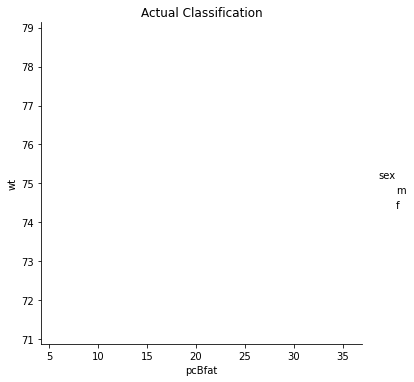

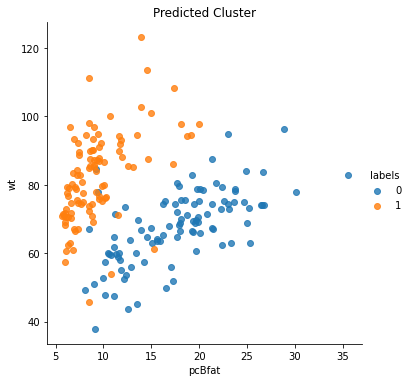

In [23]:
sns.lmplot(x='pcBfat', y='wt', data=df, hue='sex', 
           hue_order=['m', 'f'], fit_reg=False)
plt.title('Actual Classification')

sns.lmplot(x='pcBfat', y='wt', data=df, hue='labels', fit_reg=False)
plt.title('Predicted Cluster')
plt.show();

[[21.04362069 72.80862069]
 [11.82595238 56.57142857]
 [ 7.93826923 74.80961538]
 [11.9698     93.252     ]]


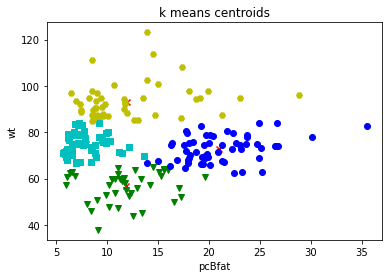

In [24]:
x1 = np.array(df['pcBfat'])
x2 = np.array(df['wt'])

# create new plot and data
plt.plot()
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)
colors = ['b', 'g', 'c', 'y']
markers = ['o', 'v', 's', 'H']

# KMeans algorithm 
K = 4
kmeans_model = KMeans(n_clusters=K).fit(X)

print(kmeans_model.cluster_centers_)
centers = np.array(kmeans_model.cluster_centers_)

plt.plot()
plt.title('k means centroids')
plt.xlabel('pcBfat')
plt.ylabel('wt')

for i, l in enumerate(kmeans_model.labels_):
    plt.plot(x1[i], x2[i], color=colors[l], marker=markers[l],ls='None')

plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')



---



---



> > > > > > > > > © 2019 Institute of Data


---



---



